## TEM image analysis
___

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.filters import sobel, threshold_otsu
from skimage.color import rgb2gray, label2rgb
from skimage import data,io,filters,measure,img_as_ubyte, segmentation, morphology
import skimage
from skimage.feature import peak_local_max
import scipy.ndimage as ndi

In [2]:
%matplotlib inline

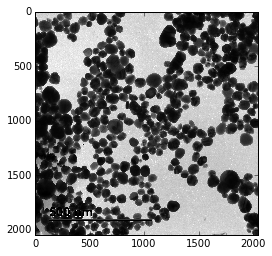

In [16]:
orig = io.imread('AgNP-12.tif')
imggray = rgb2gray(orig)
fig = plt.figure()
plt.gray()
plt.imshow(imggray)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


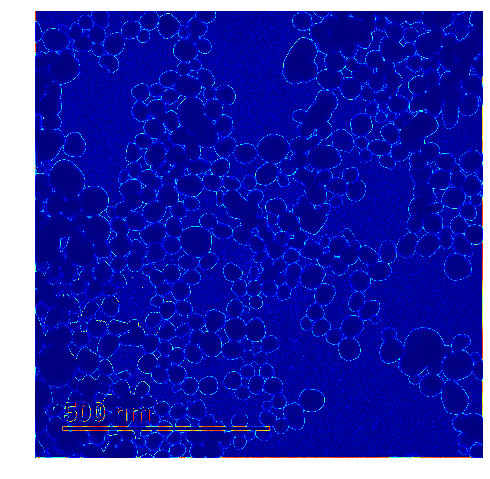

In [22]:
from skimage.filters import sobel
imginv = np.copy(imggray)
imginv = np.invert(img_as_ubyte(imginv))
elevation_map = sobel(imginv)

fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')
ax.imshow(elevation_map, cmap=plt.cm.jet, interpolation='nearest')

In [5]:
"""
markers = np.zeros_like(imggray)
markers[imggray < 140] = 1
markers[imggray > 150] = 2

fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(markers, cmap=plt.cm.spectral, interpolation='nearest')
ax.axis('off')
"""

"\nmarkers = np.zeros_like(imggray)\nmarkers[imggray < 140] = 1\nmarkers[imggray > 150] = 2\n\nfig, ax = plt.subplots(figsize=(10,8))\nax.imshow(markers, cmap=plt.cm.spectral, interpolation='nearest')\nax.axis('off')\n"

Otsu threshold: 130


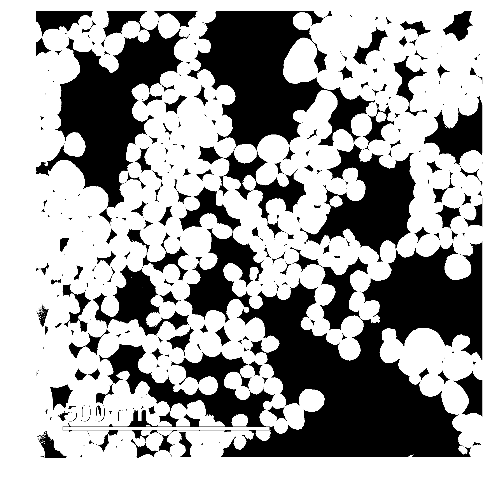

In [26]:
otsu = threshold_otsu(imginv)
imgotsu = imginv > otsu
# imgotsuinv = np.invert(imgotsu)

print("Otsu threshold:", otsu)

fig = plt.figure(1, figsize=(10,8))
plt.axis('off')
plt.imshow(imgotsu)

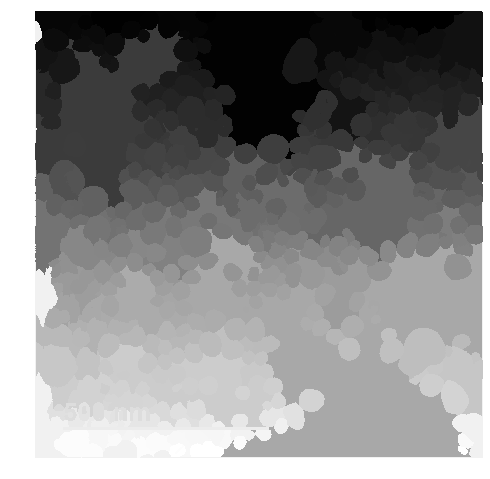

In [141]:
image = np.copy(imgotsu)
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(
    distance, indices=False, footprint=np.ones((11,11)), labels=image)
markers = measure.label(local_maxi)

segmentation = morphology.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(10,8))
ax.axis('off')
ax.imshow(segmentation, interpolation='nearest')

Number of regions: 487


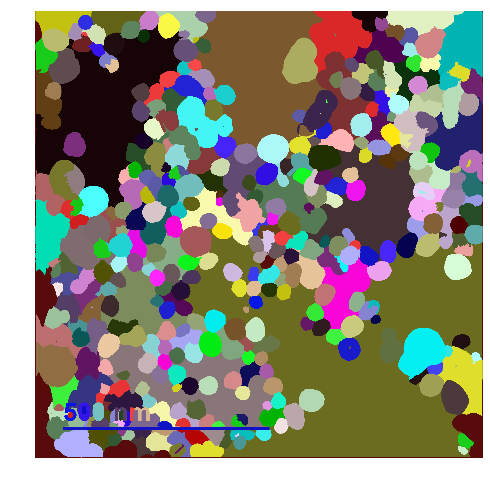

In [139]:
imglbl, numlbls = measure.label(segmentation, connectivity=1, return_num=True)
imgoverlay = label2rgb(imglbl, image=segmentation.astype(float))

print("Number of regions:", numlbls)

plt.figure(figsize=(10,8))
plt.axis('off')
axes = plt.imshow(imgoverlay)

In [127]:
regions = measure.regionprops(imglbl)

# Find labels with desired properties

ecc = []
area = []
solid = []
ext = []
perim = []
ediam = []
majax = []
minax = []
for i in range(len(regions)):
    ecc.append(regions[i].eccentricity)
    area.append(regions[i].area)
    perim.append(regions[i].perimeter)
    ediam.append(regions[i].equivalent_diameter)
    majax.append(regions[i].major_axis_length)
    minax.append(regions[i].minor_axis_length)
    ext.append(regions[i].extent)
    
#    solid.append(regions[i].solidity)
#    extent.append(regions[i].extent)

In [129]:
ecirc = np.pi*np.array(ediam)
ds = list(zip(ecc, area, perim, ecirc.tolist(), minax, majax, ext))
cols = ['Ecc','Area','Perimeter', 'EquivCircleCircum', 'MinorAxis', 'MajorAxis', 'Extent']
df = pd.DataFrame(ds, columns=cols)

Identified NPs: 20
0.237648221344 1.0


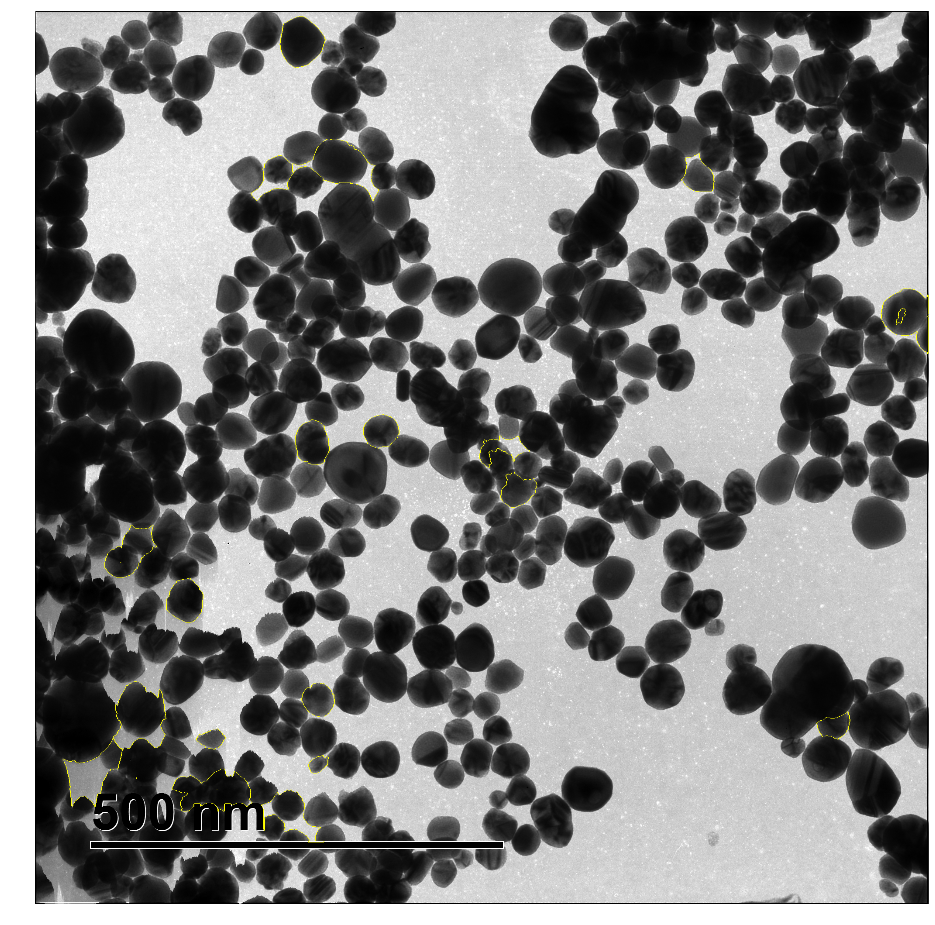

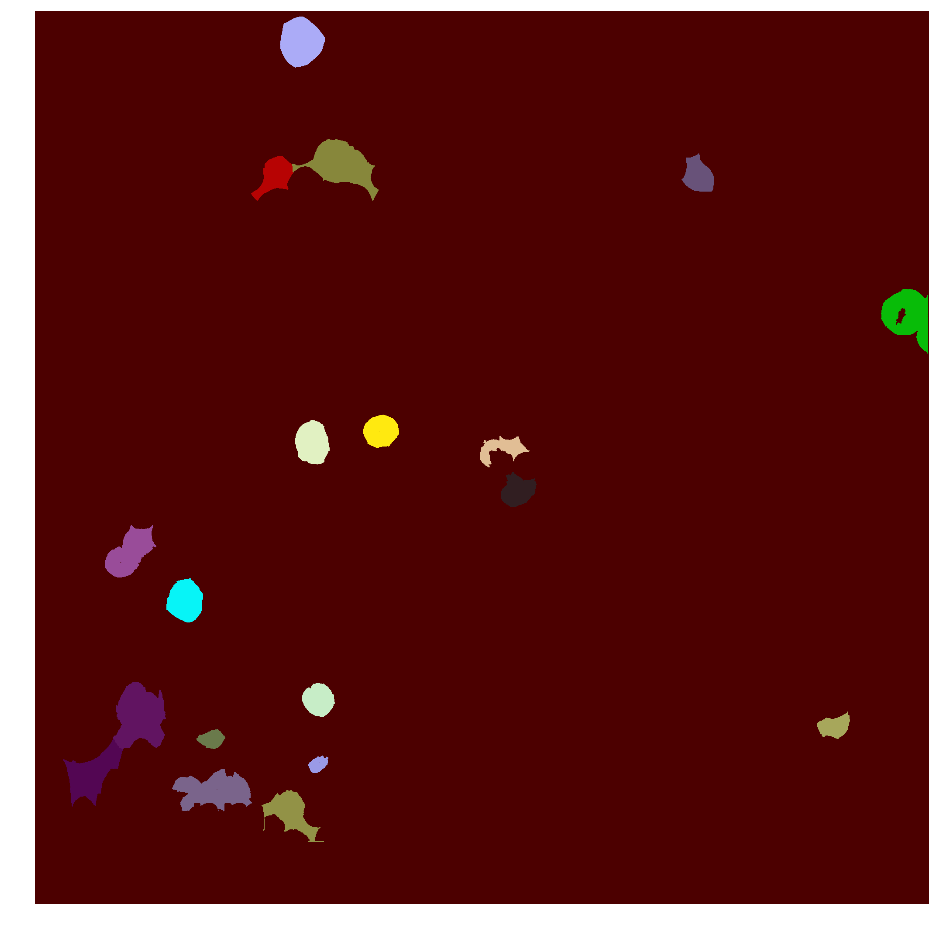

In [140]:
atest = df.Perimeter/df.EquivCircleCircum
# nps = df[(df.Ecc<0.5) & (df.Area>1000) & (df.MinorAxis/df.MajorAxis>0.92) & (atest<1.5) & (df.Extent>0.8)]
nps = df[(df.Area>1000) & (df.Area<7000) & (df.Extent>0.7) & (df.MinorAxis/df.MajorAxis>0.90)]

print("Identified NPs:", len(nps))
print(min(ext), max(ext))

# Select the labels found above
# imglbl = skimage.segmentation.clear_border(imglbl)
mask = np.in1d(imglbl.flatten(),nps.index)
select = imglbl*mask.reshape(imglbl.shape)
# set(select.flatten().tolist())

# Plot the labels found above

imgselect = label2rgb(select, image=select.astype(float))



plt.figure(figsize=(16,16))
plt.axis('off')
axes1 = plt.imshow(skimage.segmentation.mark_boundaries(imggray.astype(float), select))

plt.figure(figsize=(16,16))
plt.axis('off')
axes2 = plt.imshow(imgselect)

In [142]:
nps

,Ecc,Area,Perimeter,EquivCircleCircum,MinorAxis,MajorAxis,Extent
11,0.176395,3617,229.793939,213.196066,67.383486,68.456930,0.782223
62,0.401145,5889,302.149278,272.035580,83.175412,90.801412,0.743842
65,0.354651,4801,281.722871,245.623992,76.109679,81.400841,0.771245
67,0.259453,5141,278.149278,254.172601,80.029927,82.867680,0.728600
133,0.353337,5857,329.220346,271.295471,84.199796,90.005504,0.774735
215,0.342482,6910,326.249783,294.675450,91.150808,97.018044,0.800417
219,0.314436,5069,274.249783,252.386475,78.578943,82.777521,0.727051
226,0.419640,6192,301.651804,278.946172,85.291838,93.965739,0.819807
258,0.298505,6450,337.220346,284.698245,89.519619,93.795961,0.730713
293,0.368107,4200,249.829473,229.736276,70.708791,76.048677,0.747863
